# Modeling Climate and Housing Data: Regression
## 90-803 Machine Learning Foundations with Python (Spring 2024)
### Team 17: Yoko, Tessa, Hannah

We are attempting to predict home values (or purchase prices) based on climate indicators, so in this file we are exploring the following:
* Linear Regression
* Polynomial Regressions
* Feature selection

This file should answer the following question:
Can we predict real estate purchase price based on climate indicators?

In [24]:
# importing relevant libraries
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import geopandas as gpd
%matplotlib inline

# Importing metrics for model evaluation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.feature_selection import SequentialFeatureSelector

# Importing class balance tools for handling imbalanced datasets
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from yellowbrick.target import ClassBalance

# Importing classifier models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

## Read the data and look at it

In [25]:
state_to_fips = {
    "AL": "01",
    "AK": "02",
    "AZ": "04",
    "AR": "05",
    "CA": "06",
    "CO": "08",
    "CT": "09",
    "DE": "10",
    "DC": "11",
    "FL": "12",
    "GA": "13",
    "HI": "15",
    "ID": "16",
    "IL": "17",
    "IN": "18",
    "IA": "19",
    "KS": "20",
    "KY": "21",
    "LA": "22",
    "ME": "23",
    "MD": "24",
    "MA": "25",
    "MI": "26",
    "MN": "27",
    "MS": "28",
    "MO": "29",
    "MT": "30",
    "NE": "31",
    "NV": "32",
    "NH": "33",
    "NJ": "34",
    "NM": "35",
    "NY": "36",
    "NC": "37",
    "ND": "38",
    "OH": "39",
    "OK": "40",
    "OR": "41",
    "PA": "42",
    "RI": "44",
    "SC": "45",
    "SD": "46",
    "TN": "47",
    "TX": "48",
    "UT": "49",
    "VT": "50",
    "VA": "51",
    "WA": "53",
    "WV": "54",
    "WI": "55",
    "WY": "56",
}


In [26]:
data = pd.read_csv("all_data.csv", index_col=0)
data.head()

,Date,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),1901-2000 Mean,StateAbbrv,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%)
0,2000-01-31,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,47.8,CA,0.93,8.01,15,103.0,173.6,64.7,7.0
1,2000-01-31,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,47.8,CA,0.81,8.20,30,129.9,166.8,81.1,61.1
2,2000-01-31,2000,1,Cook County,IL,71689.188026,302264.545103,24.9,2.4,22.5,IL,0.93,8.01,15,103.0,173.6,64.7,7.0
3,2000-01-31,2000,1,Cook County,IL,71689.188026,302264.545103,24.9,2.4,22.5,IL,0.81,8.20,30,129.9,166.8,81.1,61.1
4,2000-01-31,2000,1,Harris County,TX,61195.175569,217850.462915,57.4,5.6,51.8,TX,0.93,8.01,15,103.0,173.6,64.7,7.0


In [27]:
data.drop(columns=['Date'], inplace=True)
data.rename(columns={'Value': 'Average Temperature Value'}, inplace=True)
data['StateFPS'] = data['StateAbbrv'].map(state_to_fips)

## Read in Geo-data
We want to relate this data to where the counties exist in geospatial relation to one another, so we are going to read county longitude and latitude data and merge it.

In [28]:
# Loading the shapefile in order to visualize clean data on the US map
us_counties = gpd.read_file('tl_2022_us_county/tl_2022_us_county.shp')
print(us_counties.columns)
us_counties.head()

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')


,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477644346,10691216,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980770,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,None,None,A,2169272978,22847034,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.52330, -96.69219 40.523..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645185,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27370 40.11840, -98.27374 40.122..."


In [29]:
# Merge the geospatial United States map with the data
data = data.merge(us_counties, left_on=['RegionName', 'StateFPS'], right_on=['NAMELSAD', 'STATEFP'])

data.head()

,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,StateAbbrv,...,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,47.8,CA,...,G4020,None,None,None,A,10515988166,1785003207,+34.1963983,-118.2618616,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756..."
1,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,47.8,CA,...,G4020,None,None,None,A,10515988166,1785003207,+34.1963983,-118.2618616,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756..."
2,2000,1,Cook County,IL,71689.188026,302264.545103,24.9,2.4,22.5,IL,...,G4020,None,None,None,A,2447342616,1786339408,+41.8942937,-087.6454546,"POLYGON ((-87.52500 41.64464, -87.52505 41.639..."
3,2000,1,Cook County,IL,71689.188026,302264.545103,24.9,2.4,22.5,IL,...,G4020,None,None,None,A,2447342616,1786339408,+41.8942937,-087.6454546,"POLYGON ((-87.52500 41.64464, -87.52505 41.639..."
4,2000,1,Harris County,TX,61195.175569,217850.462915,57.4,5.6,51.8,TX,...,G4020,None,None,None,A,4421145870,182187806,+29.8572730,-095.3930371,"POLYGON ((-94.97885 29.67673, -94.97918 29.676..."


## Look for multicollinearity

We suspect that housing values may simply change over time due to factors not listed in our dataset, which would make the Year (and possibly the Month) column heavily collinear. As we see below, it does have high collinearity with some features. We will proceed, anyway, but we will keep this in mind.

In [30]:
data.drop(columns=['RegionName', 'State', 'StateAbbrv', \
                       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).corr()

,Year,Month,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),StateFPS,ALAND,AWATER,INTPTLAT,INTPTLON
Year,1.000000e+00,-4.617339e-02,1.187070e-01,5.142580e-02,-2.184026e-02,7.997439e-02,-3.772959e-02,0.839877,-0.838237,1.134368e-17,0.732249,0.762318,0.292253,0.001292,3.323953e-02,1.283811e-02,-2.641111e-02,9.763769e-03,-6.955544e-02
Month,-4.617339e-02,1.000000e+00,2.403291e-03,2.583203e-03,2.249476e-01,4.517619e-03,2.245213e-01,0.016489,-0.019669,-6.127168e-20,0.008787,0.000493,0.010513,0.001848,-1.076143e-04,-7.532422e-04,9.360826e-05,1.562084e-04,3.452991e-04
Bottom-Tier Average Home Value Estimate,1.187070e-01,2.403291e-03,1.000000e+00,8.037582e-01,-6.602504e-02,7.475002e-02,-8.097716e-02,0.052192,-0.053026,-9.822150e-20,0.110418,0.144230,0.022258,-0.002450,-2.159540e-02,1.132833e-01,1.254250e-01,1.752318e-01,-2.423438e-01
Top-Tier Average Home Value Estimate,5.142580e-02,2.583203e-03,8.037582e-01,1.000000e+00,-4.801156e-02,5.180984e-02,-5.838083e-02,0.005629,-0.015362,-4.024007e-20,0.054516,0.078842,0.007353,-0.002382,-5.883734e-02,6.851009e-02,1.327252e-01,9.092880e-02,-1.690133e-01
Average Temperature Value,-2.184026e-02,2.249476e-01,-6.602504e-02,-4.801156e-02,1.000000e+00,1.093690e-01,9.804183e-01,0.007599,0.007542,2.671481e-19,0.008831,0.008076,0.003013,-0.010295,-9.624441e-02,-1.368676e-02,-4.111847e-03,-4.299962e-01,2.712204e-02
Anomaly (1901-2000 base period),7.997439e-02,4.517619e-03,7.475002e-02,5.180984e-02,1.093690e-01,1.000000e+00,-8.851724e-02,0.105022,-0.067825,6.117907e-20,0.034811,0.036166,0.016583,-0.015012,1.373802e-02,3.385159e-02,2.391780e-02,4.241406e-02,2.002032e-03
1901-2000 Mean,-3.772959e-02,2.245213e-01,-8.097716e-02,-5.838083e-02,9.804183e-01,-8.851724e-02,1.000000e+00,-0.013191,0.020994,1.287881e-19,0.001953,0.000928,-0.000267,-0.007343,-9.916603e-02,-2.042295e-02,-8.859283e-03,-4.392965e-01,2.678733e-02
Initial Fees and Charges (%),8.398768e-01,1.648891e-02,5.219225e-02,5.629394e-03,7.599125e-03,1.050216e-01,-1.319141e-02,1.000000,-0.682275,1.356500e-01,0.662479,0.534082,0.399342,0.115833,3.150113e-02,1.254111e-02,-2.387347e-02,7.123955e-03,-6.014024e-02
Effective Rate (%),-8.382365e-01,-1.966874e-02,-5.302615e-02,-1.536246e-02,7.541816e-03,-6.782457e-02,2.099445e-02,-0.682275,1.000000,1.901198e-01,-0.501865,-0.639847,-0.113243,0.187043,-3.510434e-02,-1.215095e-02,2.460028e-02,-1.001319e-02,6.586597e-02
Term to Maturity,1.134368e-17,-6.127168e-20,-9.822150e-20,-4.024007e-20,2.671481e-19,6.117907e-20,1.287881e-19,0.135650,0.190120,1.000000e+00,0.582567,-0.034457,0.855501,0.985514,-2.052343e-19,-3.262439e-20,2.977157e-22,2.385547e-19,-1.055074e-19


<Axes: >

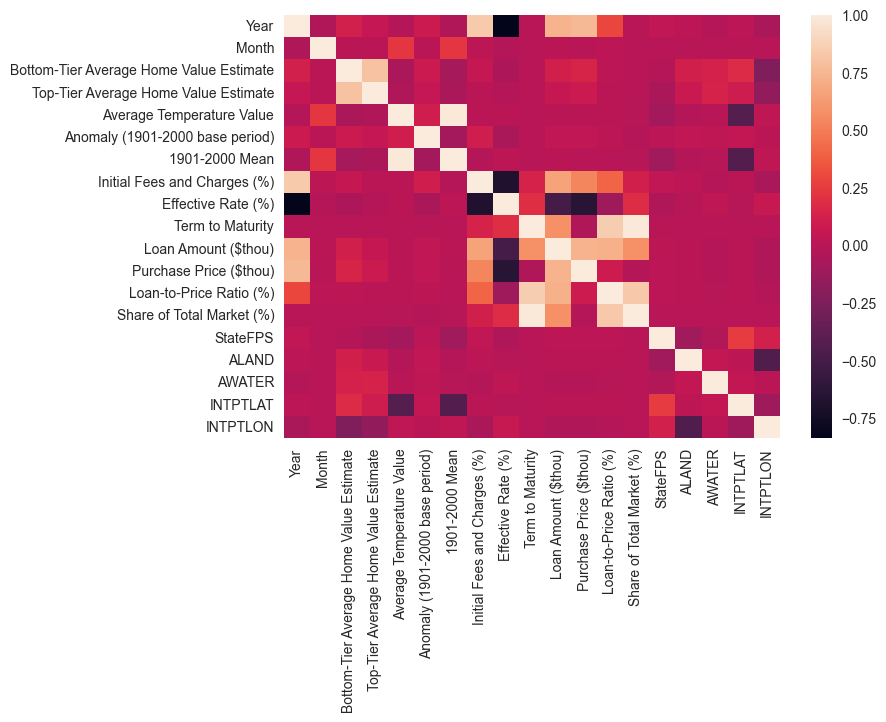

In [31]:
sns.heatmap(data=data.drop(columns=['RegionName', 'State', 'StateAbbrv', \
                       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).corr())

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579894 entries, 0 to 579893
Data columns (total 36 columns):
 #   Column                                   Non-Null Count   Dtype   
---  ------                                   --------------   -----   
 0   Year                                     579894 non-null  int64   
 1   Month                                    579894 non-null  int64   
 2   RegionName                               579894 non-null  object  
 3   State                                    579894 non-null  object  
 4   Bottom-Tier Average Home Value Estimate  579894 non-null  float64 
 5   Top-Tier Average Home Value Estimate     579894 non-null  float64 
 6   Average Temperature Value                579894 non-null  float64 
 7   Anomaly (1901-2000 base period)          579894 non-null  float64 
 8   1901-2000 Mean                           579894 non-null  float64 
 9   StateAbbrv                               579894 non-null  object  
 10  Initial Fees and Cha

## Split the data
Because this data is origianlly time series, we have broken the year and month into their own columns and dropped the date. Next, we are going to use the latest year as the "test" dataset and all previous years as training.

In [33]:
test = data[data['Year'] == 2019].copy()
train = data[data['Year'] != 2019].copy()
y_test = test['Purchase Price ($thou)'].copy()
y_train = train['Purchase Price ($thou)'].copy()
X_train = train.drop(columns=['RegionName', 'State', 'StateAbbrv', 'Purchase Price ($thou)', \
                       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).copy()
X_test = test.drop(columns=['RegionName', 'State', 'StateAbbrv', 'Purchase Price ($thou)', \
                       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).copy()


In [34]:
X_train.columns

Index(['Year', 'Month', 'Bottom-Tier Average Home Value Estimate',
       'Top-Tier Average Home Value Estimate', 'Average Temperature Value',
       'Anomaly (1901-2000 base period)', '1901-2000 Mean',
       'Initial Fees and Charges (%)', 'Effective Rate (%)',
       'Term to Maturity', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)',
       'Share of Total Market (%)', 'StateFPS', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON'],
      dtype='object')

## Train a Linear Regression Model

In [35]:
# your code here
l_model = LinearRegression()
l_model.fit(X_train, y_train)
y_pred_test = l_model.predict(X_test)
y_pred_train = l_model.predict(X_train)

r_squared_train_linear = r2_score(y_train, y_pred_train)
r_squared_test_linear = r2_score(y_test, y_pred_test)

mean_squared_error_train_linear = mean_squared_error(y_train, y_pred_train)
mean_squared_error_test_linear = mean_squared_error(y_test, y_pred_test)

# Printing results for training
print('r_squared_train:', round(r_squared_train_linear, 3))
print('mean_squared_error_train:', round(mean_squared_error_train_linear, 3))

# Printing results for testing
print('r_squared_test:',round(r_squared_test_linear, 3))
print('mean_squared_error_test:',round(mean_squared_error_test_linear, 3))


r_squared_train: 0.964
mean_squared_error_train: 46.596
r_squared_test: 0.548
mean_squared_error_test: 44.719


The training data did incredibly well where the test data did just OK. The MSE values for both are decently low but there is a mismatch with R2 values. This seems suspicious -- I think it may be due to the Year column.

I am going to check which features are most important below.

## Feature Selection

In [36]:
for i in range(1,5):
    sfs = SequentialFeatureSelector(estimator=LinearRegression(),
                              n_features_to_select=i,
                              direction = 'forward',
                              scoring = 'neg_mean_squared_error')
    sfs = sfs.fit(X_train, y_train)

    feature_names = np.array(X_train.columns)
    selected_feature_names = feature_names[sfs.get_support()].tolist()
    print("Selected features:", selected_feature_names)

Selected features: ['Year']
Selected features: ['Year', 'Loan-to-Price Ratio (%)']
Selected features: ['Year', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)']
Selected features: ['Year', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)', 'Share of Total Market (%)']


As I suspected, Year is the most important, almost certainly due to factors not in this dataset.

Next, I am going to drop the Year column and see what happens.

In [37]:
# Try again without "Year" data because it seems too strongly correlated and we are trying to do this based on climate data...
test = data[data['Year'] == 2019].copy()
train = data[data['Year'] != 2019].copy()
y_test = test['Purchase Price ($thou)'].copy()
y_train = train['Purchase Price ($thou)'].copy()
X_train = train.drop(columns=['Year', 'RegionName', 'State', 'StateAbbrv', 'Purchase Price ($thou)', \
                       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).copy()
X_test = test.drop(columns=['Year', 'RegionName', 'State', 'StateAbbrv', 'Purchase Price ($thou)', \
                       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).copy()


In [38]:
# your code here
l_model = LinearRegression()
l_model.fit(X_train, y_train)
y_pred_test = l_model.predict(X_test)
y_pred_train = l_model.predict(X_train)

r_squared_train_linear = r2_score(y_train, y_pred_train)
r_squared_test_linear = r2_score(y_test, y_pred_test)

mean_squared_error_train_linear = mean_squared_error(y_train, y_pred_train)
mean_squared_error_test_linear = mean_squared_error(y_test, y_pred_test)

# Printing results for training
print('r_squared_train:', round(r_squared_train_linear, 3))
print('mean_squared_error_train:', round(mean_squared_error_train_linear, 3))

# Printing results for testing
print('r_squared_test:',round(r_squared_test_linear, 3))
print('mean_squared_error_test:',round(mean_squared_error_test_linear, 3))


r_squared_train: 0.963
mean_squared_error_train: 48.538
r_squared_test: 0.307
mean_squared_error_test: 68.547


Already, we see the R2 for the test dataset go down to 0.31. The Year was a big feature. I want to also try dropping some of those other features that are not related to climate. I will drop 'Loan-to-Price Ratio (%)'.

In [39]:
# Try again without "Year" data because it seems too strongly correlated and we are trying to do this based on climate data...
test = data[data['Year'] == 2019].copy()
train = data[data['Year'] != 2019].copy()
y_test = test['Purchase Price ($thou)'].copy()
y_train = train['Purchase Price ($thou)'].copy()
X_train = train.drop(columns=['Year', 'Loan-to-Price Ratio (%)', 'RegionName', 'State', 'StateAbbrv', 'Purchase Price ($thou)', \
                       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).copy()
X_test = test.drop(columns=['Year', 'RegionName', 'Loan-to-Price Ratio (%)', 'State', 'StateAbbrv', 'Purchase Price ($thou)', \
                       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).copy()


In [40]:
# your code here
l_model = LinearRegression()
l_model.fit(X_train, y_train)
y_pred_test = l_model.predict(X_test)
y_pred_train = l_model.predict(X_train)

r_squared_train_linear = r2_score(y_train, y_pred_train)
r_squared_test_linear = r2_score(y_test, y_pred_test)

mean_squared_error_train_linear = mean_squared_error(y_train, y_pred_train)
mean_squared_error_test_linear = mean_squared_error(y_test, y_pred_test)

# Printing results for training
print('r_squared_train:', round(r_squared_train_linear, 3))
print('mean_squared_error_train:', round(mean_squared_error_train_linear, 3))

# Printing results for testing
print('r_squared_test:',round(r_squared_test_linear, 3))
print('mean_squared_error_test:',round(mean_squared_error_test_linear, 3))


r_squared_train: 0.879
mean_squared_error_train: 158.229
r_squared_test: 0.34
mean_squared_error_test: 65.232


The R2 for the test dataset suspicously went up just a little bit. I am going to remove the next most important feature next to see when the model breaks: 'Loan Amount ($thou)'.

In [41]:
# Try again without "Year" data because it seems too strongly correlated and we are trying to do this based on climate data...
test = data[data['Year'] == 2019].copy()
train = data[data['Year'] != 2019].copy()
y_test = test['Purchase Price ($thou)'].copy()
y_train = train['Purchase Price ($thou)'].copy()
X_train = train.drop(columns=['Year', 'Loan-to-Price Ratio (%)', 'Loan Amount ($thou)', 'RegionName', 'State', 'StateAbbrv', 'Purchase Price ($thou)', \
                       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).copy()
X_test = test.drop(columns=['Year', 'RegionName', 'Loan-to-Price Ratio (%)', 'Loan Amount ($thou)', 'State', 'StateAbbrv', 'Purchase Price ($thou)', \
                       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).copy()


In [42]:
# your code here
l_model = LinearRegression()
l_model.fit(X_train, y_train)
y_pred_test = l_model.predict(X_test)
y_pred_train = l_model.predict(X_train)

r_squared_train_linear = r2_score(y_train, y_pred_train)
r_squared_test_linear = r2_score(y_test, y_pred_test)

mean_squared_error_train_linear = mean_squared_error(y_train, y_pred_train)
mean_squared_error_test_linear = mean_squared_error(y_test, y_pred_test)

# Printing results for training
print('r_squared_train:', round(r_squared_train_linear, 3))
print('mean_squared_error_train:', round(mean_squared_error_train_linear, 3))

# Printing results for testing
print('r_squared_test:',round(r_squared_test_linear, 3))
print('mean_squared_error_test:',round(mean_squared_error_test_linear, 3))


r_squared_train: 0.45
mean_squared_error_train: 718.121
r_squared_test: -20.147
mean_squared_error_test: 2091.657


Clearly, removing features that are related to TIME or related to HOUSING breaks the model -- which kind of indicates that attempting to predict housing purchase prices based solely on geographical and climate data is WORSE than random!

**This likely means we need to go back to the drawing board.** 

To be certain, I will try a higher degree polynomial below.

## Polynomial Features
First, I am resetting the test and train datasets back to have the most informatio possible.

In [43]:
test = data[data['Year'] == 2019].copy()
train = data[data['Year'] != 2019].copy()
y_test = test['Purchase Price ($thou)'].copy()
y_train = train['Purchase Price ($thou)'].copy()
X_train = train.drop(columns=['RegionName', 'State', 'StateAbbrv', 'Purchase Price ($thou)', \
                       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).copy()
X_test = test.drop(columns=['RegionName', 'State', 'StateAbbrv', 'Purchase Price ($thou)', \
                       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).copy()


In [44]:
# y_poly_preds = []
# for x in range(1,5):
#     X_poly = PolynomialFeatures(degree=x)
#     X_polynomial_train = X_poly.fit_transform(X_train)
#     X_polynomial_test = X_poly.fit_transform(X_test)
#     model_poly = LinearRegression()
#     model_poly.fit(X_polynomial_train, y_train)

#     y_pred_poly_test = model_poly.predict(X_polynomial_test)
#     y_pred_poly_train = model_poly.predict(X_polynomial_train)
#     y_poly_preds.append(y_pred_poly_test)

#     r_squared_train_poly = model_poly.score(X_polynomial_train, y_train)
#     r_squared_test_poly = model_poly.score(X_polynomial_test, y_test)

#     mean_squared_error_train_poly = mean_squared_error(y_train, y_pred_poly_train)
#     mean_squared_error_test_poly = mean_squared_error(y_test, y_pred_poly_test)

#     # Printing results for training
#     print('----------------------------')
#     print("Degree: ", x)
#     print('r_squared_train:', r_squared_train_poly)
#     print('mean_squared_error_train:', mean_squared_error_train_poly)

#     # Printing results for testing
#     print('r_squared_test:',r_squared_test_poly)
#     print('mean_squared_error_test:',mean_squared_error_test_poly)
#     print('----------------------------')
#     print("")

Below, I have pasted an image of the output produced by this code. Above, the code is commented out, because it fails due to memory allocation. This makes sense because the dataset is currently 2.7 million rows, and attempting to fit higher-order polynomials simply requries more memory than can be allocated by my computer. The result:
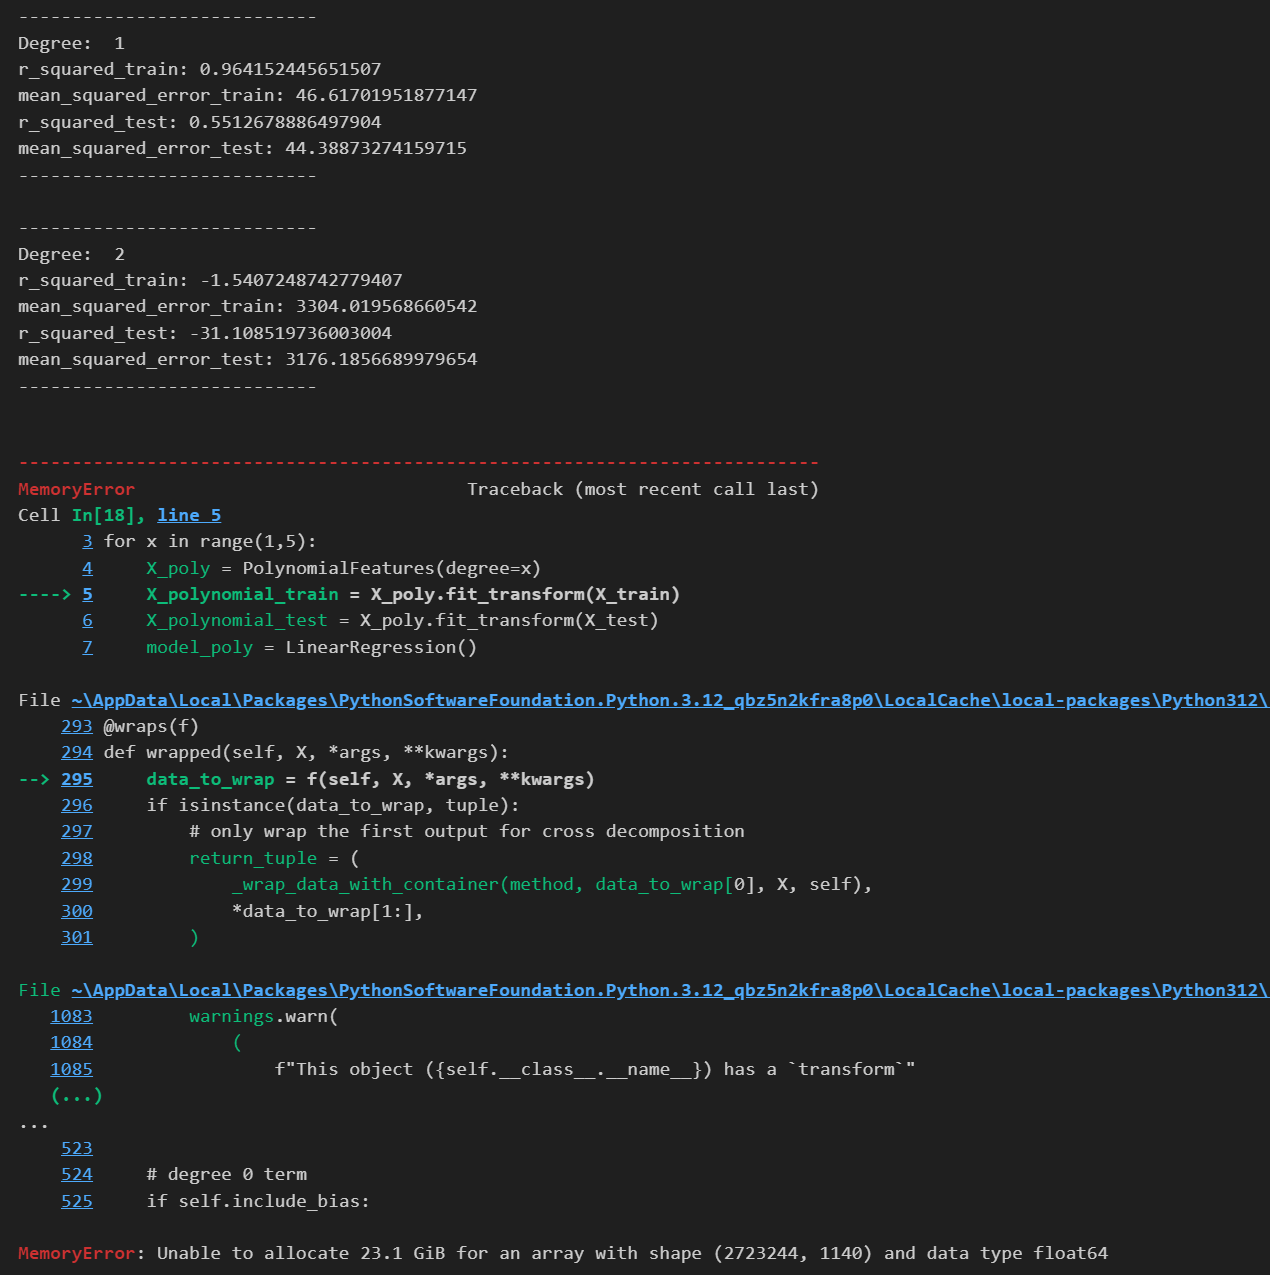

## Closing Thoughts

The data so far indicates that we may need to change either our questions or our entire dataset. Our hypothesis that temperature change can be used to predict purchase price is "No, that in fact is worse than random."